## notebook to create mock lightcurves from SALT2 model

In [1]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
from sklearn.decomposition import PCA

import sncosmo
 
plt.rcParams.update({'font.family' : 'lmodern', 'font.size': 16,                                                                                                                                                    
                     'axes.labelsize': 16, 'legend.fontsize': 12, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.titlesize': 16,
                     'axes.linewidth': 1.5})     

In [2]:
snmodel = sncosmo.Model(source='SALT2')
print('paramaters are: ', snmodel.param_names)

def get_flux(wavelength, tobs=0, z=0., x0=1., x1=0.0, c=0.0, t0=0.):
    '''returns SALT2 SN spectra in ergs/s/cm^2/Angstrom'''
    snmodel.set(z=z, x0=x0, x1=x1, c=c, t0=t0)
    return snmodel.flux(tobs, wavelength) 

paramaters are:  ['z', 't0', 'x0', 'x1', 'c']


In [3]:
#overall scaling (~distance)
x0   = 1.
# factor in front of second component
x1min= -0.3; x1max= 0.3 # [-3, 3] flat distribution
# color correction
cmin = -0.1; cmax = 0.5  # [-0.1, 0.5] flat distribution
# redshift
zmin = 0.3;  zmax = 0.8  # [0.3, 0.8] flat distribution
# time in days respective to maximum
tmin = -10;  tmax = 10   # [-10, 20] flat distribution

In [4]:
#number of lightcurves
n_samples = 20000

In [5]:
#light curve params
x1_sample = np.random.random_sample([n_samples])*(x1max-x1min)+x1min
c_sample  = np.random.random_sample([n_samples])*(cmax-cmin)+cmin

In [6]:
# redshifts and time
z_sample  = np.random.random_sample([n_samples])*(zmax-zmin)+zmin
t_sample  = np.random.random_sample([n_samples])*(tmax-tmin)+tmin

In [7]:
# wavelength range
lmin = 3750
lmax = 11500 # lmin, lmax chosen to be within model wavelength range bewteen z=[0.3, 0.8]
nlbin = lmax-lmin+1
l = np.linspace(lmin,lmax,nlbin)

In [8]:
sn_spectra = np.zeros((n_samples,nlbin))
for i in range(n_samples):
    sn_spectra[i,:] = get_flux(l, tobs=t_sample[i], z=z_sample[i], x0=x0, x1=x1_sample[i], c=c_sample[i])

findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.


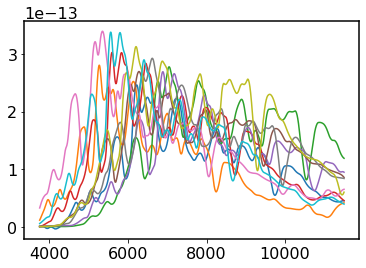

In [9]:
for ii in range(10):
    plt.plot(l,sn_spectra[ii,:])

In [10]:
cwd  = os.getcwd()
path = os.path.join(cwd,'salt2')
if not os.path.isdir(path):
    os.makedirs(path)

In [11]:
filename = os.path.join(path,'salt2_spectra_raw.npy')
np.save(filename,[l, sn_spectra])

In [12]:
train_frac = 0.8
train_num  = int(train_frac*n_samples)
print(train_num)
assert(train_num>sn_spectra.shape[-1])
train_specs= sn_spectra[0:train_num]
test_specs = sn_spectra[train_num::]

16000


### at first inspect 'raw' data (not de-redshifted, random time and redshift)

In [13]:
n_components = 50
pca          = PCA(n_components=n_components)

In [14]:
pca.fit(train_specs)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [15]:
recons = pca.inverse_transform(pca.transform(test_specs))

findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.
findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.


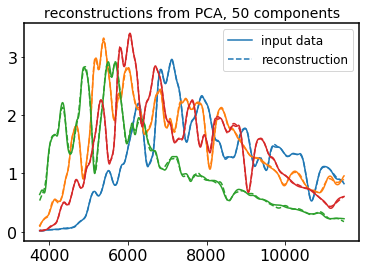

In [16]:
#100 components is practically exact, 10 is insufficient, still spurious oscillations for 50 conmponents
norm= 1e-13
plt.title('reconstructions from PCA, %d components'%n_components, fontsize=14)
for ii in range(4):
    if ii==0:
        ll= plt.plot(l,test_specs[ii]/norm, label='input data')
        plt.plot(l,recons[ii]/norm,c=ll[0].get_color(), ls='--', label='reconstruction')
    else:
        ll= plt.plot(l,test_specs[ii]/norm)
        plt.plot(l,recons[ii]/norm,c=ll[0].get_color(), ls='--')        
    plt.legend(fontsize=12)

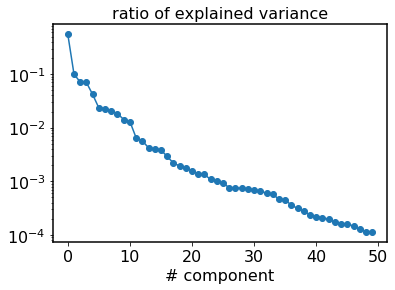

In [17]:
var = pca.explained_variance_ratio_
plt.title('ratio of explained variance')
plt.semilogy(var,marker='o')
plt.xlabel('# component')
plt.show()

### downsample

In [18]:
from scipy import stats
new_size = 256
l_b_edge = np.linspace(lmin, lmax, new_size+1) #linear bins
l_b      = (l_b_edge[1:]+l_b_edge[:-1])/2 # linear bin center

train_specs_ds, l_b_edge, binnumber = stats.binned_statistic(l,train_specs, statistic='mean', bins=l_b_edge)
test_specs_ds, l_b_edge, binnumber = stats.binned_statistic(l,test_specs, statistic='mean', bins=l_b_edge)
specs_ds, l_b_edge, binnumber = stats.binned_statistic(l,sn_spectra, statistic='mean', bins=l_b_edge)



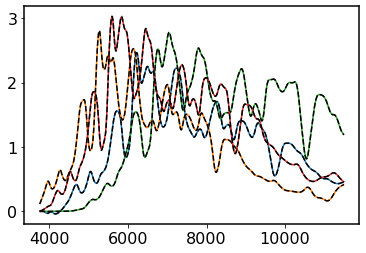

In [19]:
#compare to high resolution data -> no visual difference
for ii in range(4):
    plt.plot(l_b,train_specs_ds[ii,:]/norm)
    plt.plot(l,train_specs[ii,:]/norm,c='black', ls='--')

In [20]:
n_components = 100
pca          = PCA(n_components=n_components)
pca.fit(train_specs_ds)
recons = pca.inverse_transform(pca.transform(test_specs_ds))

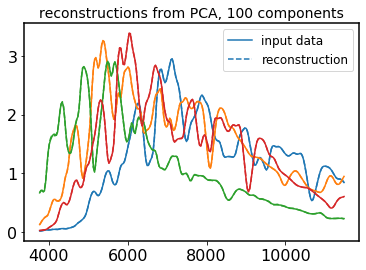

In [21]:
#100 components is practically exact, 10 is insufficient, still spurious oscillations for 50 conmponents
norm= 1e-13
plt.title('reconstructions from PCA, %d components'%n_components, fontsize=14)
for ii in range(4):
    if ii==0:
        ll= plt.plot(l_b,test_specs_ds[ii]/norm, label='input data')
        plt.plot(l_b,recons[ii]/norm,c=ll[0].get_color(), ls='--', label='reconstruction')
    else:
        ll= plt.plot(l_b,test_specs_ds[ii]/norm)
        plt.plot(l_b,recons[ii]/norm,c=ll[0].get_color(), ls='--')        
    plt.legend(fontsize=12)

In [22]:
filename = os.path.join(path,'salt2_spectra_downsampled.npy')
np.save(filename,[l_b,specs_ds])

### de-redshift

In [23]:
#how do we treat missing wavelengths information? George adjusts to smallest common range, but can we just treat it as missing data?


In [24]:
import math
from scipy import interpolate

lmin_dr  = math.ceil(min(l)/(1+zmin))  # minimum wavelength at z=0
lmax_dr  = math.floor(max(l)/(1+zmax)) # maximim wavelength at z=0
nlbin_dr = 256

print("min, max, wavelength available after de-redshifting", lmin_dr, lmax_dr)

l_dr = np.linspace(lmin_dr, lmax_dr, nlbin_dr)
sn_spectra_dr = np.zeros((n_samples, nlbin_dr)) 

for i in range(n_samples):
    a_inv = z_sample[i] + 1

    f_dr = interpolate.interp1d(l/a_inv, sn_spectra[i,:] * a_inv) 

    sn_spectra_dr[i,:] = f_dr(l_dr)
    
train_specs_dr = sn_spectra_dr[0:train_num]
test_specs_dr  = sn_spectra_dr[train_num::]

min, max, wavelength available after de-redshifting 2885 6388


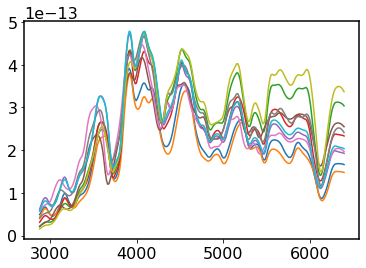

In [25]:
for ii in range(10):
    plt.plot(l_dr,sn_spectra_dr[ii])

In [26]:
n_components = 100
pca          = PCA(n_components=n_components)
pca.fit(train_specs_dr)
recons = pca.inverse_transform(pca.transform(test_specs_dr))

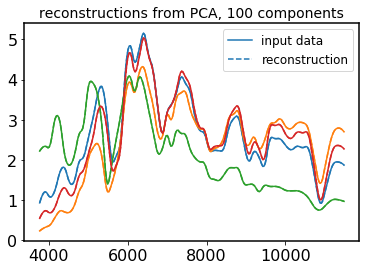

In [27]:
#almost perfect reconstructions with 10 components only
norm= 1e-13
plt.title('reconstructions from PCA, %d components'%n_components, fontsize=14)
for ii in range(4):
    if ii==0:
        ll= plt.plot(l_b,test_specs_dr[ii]/norm, label='input data')
        plt.plot(l_b,recons[ii]/norm,c=ll[0].get_color(), ls='--', label='reconstruction')
    else:
        ll= plt.plot(l_b,test_specs_dr[ii]/norm)
        plt.plot(l_b,recons[ii]/norm,c=ll[0].get_color(), ls='--')        
    plt.legend(fontsize=12)

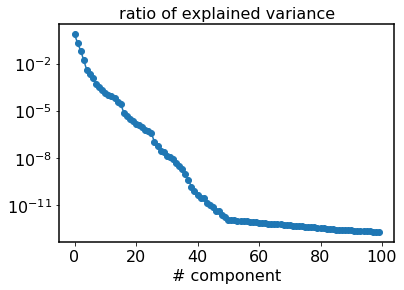

In [28]:
var = pca.explained_variance_ratio_
plt.title('ratio of explained variance')
plt.semilogy(var,marker='o')
plt.xlabel('# component')
plt.show()

In [29]:
filename = os.path.join(path,'salt2_spectra_downsampled_deredshifted.npy')
np.save(filename,[l_dr,sn_spectra_dr])

In [30]:
sn_spectra_dr.shape

(20000, 256)

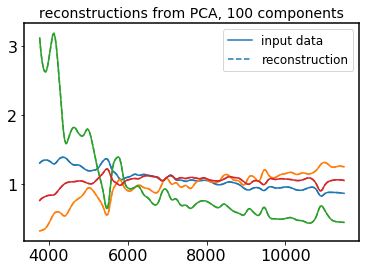

In [31]:
#normalized spectra
norm = np.mean(train_specs_dr,axis=0)
plt.title('reconstructions from PCA, %d components'%n_components, fontsize=14)
for ii in range(4):
    if ii==0:
        ll= plt.plot(l_b,test_specs_dr[ii]/norm, label='input data')
        plt.plot(l_b,recons[ii]/norm,c=ll[0].get_color(), ls='--', label='reconstruction')
    else:
        ll= plt.plot(l_b,test_specs_dr[ii]/norm)
        plt.plot(l_b,recons[ii]/norm,c=ll[0].get_color(), ls='--')        
    plt.legend(fontsize=12)